# <h1> Pre-procesamiento de imágenes </h1>

## Pasos a seguir:

1. Abrir la imágen con ayuda de openCV
2. Buscar los histogramas de cada canal en la imagen (R,G,B, Escala de grises)
3. Aplicarle un filtro gausiano (GaussianBlur) a la imagen
4. 
10. Aplicar una busqueda de umbral con un threshold binario    

# Bibliotecas a utilizar
- os (Para guardar, abrir, y moverse por el sistema de archivos)
- cv2   (Para el manejo y manipulación de imágenes)
- numpy (Para el manejo de pixeles)
- random    (Para debuggear y tener una seleccion aleatoria de imágenes)
- matplotlib    (Para el manejo de las impresiones de imágenes)

In [2]:
import os
import cv2
import numpy as np
import random

from matplotlib import pyplot as plt

%matplotlib inline

# Dirección principal
dir = "c:/Users/jose_/Desktop/Tesis/Programa"
# Direccion de guardado de imágenes
outDir = os.getcwd()+"\Imagenes"
# Direccion de carga de videos
inDir = os.getcwd()+"\Videos"
#Dirección de guardado de cada canal
outChan = os.getcwd()+"\Canales2"
#Dirección de guardado de los histogramas de cada canal
outHist = os.getcwd()+"\Histogramas2"


In [12]:
# Variables globales que contendran las imagenes y sus nombres
global imgs 
global file_names

imgs = list()
file_names = list()

### Método "getImages"
#### Obtiene las imágenes de la carpeta en el directorio Imagenes

- Entrada: No recibe nada
- Salida: Ninguna, todo se guarda en las variables globales (imgs, file_names)

In [13]:
def getImages(dir):
    # Obtenemos el nombre de todos los archivos que se encuentran en la carpeta Imagenes
    files = os.listdir(dir)                 

    # Creamos un bucle para cada elemento dentro de la carpeta    
    for file in files:
        # Creamos la variable de la direccion de cada imagen
        image_path = dir + "/" + file           
       
        # Leemos la imagen
        image = cv2.imread(image_path)   
       
        # Si por alguna cuestion no se puede leer la imagen o el archivo no es una imagen se descarta en automatico
        if image is None:                          
            continue

        # Agregamos la imagen leida a la lista de imagenes
        imgs.append(image)                        
        # Agregamos el nombre de la imagen leida a la lista de nombres
        file_names.append(file)

### Iniciamos el procesamiento de las imágenes

Parámetros:
- Entrada: Una lista de fotos a color (imgs)

______________________________________________________________________


Ahora procedemos a separar las imagenes en cada canal y guardarlas en una lista distinta cada una

In [24]:
def getChannels():
    # Creamos una lista por cada canal que utilizaremos, en este caso
    # azul, verde, rojo y escala de grises
    blueC = list()
    greenC = list()
    redC = list()
    grayC = list()

    # Recorremos la lista de imagenes para ir separando cada imagen en sus canales
    for img in imgs:

        # Separamos la imagen en sus 3 canales azul, verde y rojo
        bI, gI, rI = cv2.split(img)
        # Convertimos la imagen a escala de grises
        grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Agregamos la imagen resultante de cada canal a su respectiva lista
        blueC.append(bI)
        greenC.append(gI)
        redC.append(rI) 
        grayC.append(grayImage)


# Pruebas de funcionalidad
------------------------------------------------------------------------------

### Hacemos una busqueda de lineas rectas con el fin de proceder a recortar las imagenes y evitar ruido 
#### Los pasos que se siguieron fueron:
    - Convertir la imagen a escala de grises
    - Hacer una busqueda de bordes con los valores 50 y 150 como minimo y maximo (es decir, fuera de estos valores será considerado un borde)
    - Realizar la busqueda de lineas rectas en los bordes resultantes, en donde 300 pixeles seguidos serán considerados linea recta
    - Busqueda de las lineas mas interna, mas externa y dibujar un rectangulo entre estas lineas  

In [45]:
for img in imgs:
    
    imagen_grises = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, tresh = cv2.threshold(imagen_grises, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU )
    cv2.imshow("Imagen ", cv2.resize(tresh,(512,512)))
    # cv2.imshow("Cropped", cv2.resize(cropped,(512,512)))
    cv2.waitKey(100)

cv2.destroyAllWindows()

### Metodo para cortar las imagenes con la funcion HoughLines

In [5]:
def selectLinesToCrop():
    j = 0
    crpImg = list()
    for i in imgs:
        img = i.copy()
        crp = i.copy()

        # Cambio de imagen en color a imagen a escala de grises 
        imagen_grises = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, tresh = cv2.threshold(imagen_grises, 0, 255, cv2.THRESH_OTSU )

        # Canny es el detector de bordes
        # Imagen_ grises        Es la imagen fuente a utilizar en escala de grises
        # 50                    Valor de umbral minimo, a partir del cual se considera algo un borde
        # 150                   Valor de umbral maximo, a partir del cual se considera algo un borde
        # ApertureSize          El ancho de la linea de bordes que se deja en la imagen
        bordes = cv2.Canny(imagen_grises, 0, ret)

        # Detector de lineas
        # Bordes es la imagen resultante de aplicar Canny 
        # 1 es el radio de resolución, es decir, los saltos entre pixeles
        # pi/180 Angulo de busqueda, normalmente lleva el valor de 1 grado pero representado en coordenadas polares
        # 300 Threshld, pero no es un valor de umbral, se refiere mas bien a la cantidad de puntos minimos para considerar algo una linea 
        lineas = cv2.HoughLines(bordes, 1, np.pi/180, 200)

        # Contador para elegir el color de la linea
        cnt = 0
        # Valor minimo para la linea extrema izquierda, en este caso se puso un valor alto para que se actualice al encontrar las lineas
        min = 0
        # Valor maximo para la linea extrema derecha, en este caso se puso un valor alto para que se actualice al encontrar las lineas
        max = i.shape[1]

        # Recorremos las lineas encontradas buscando las de nuestro interés
        for linea in lineas:
            # Obtenemos los valores del radio y angulo del punto que representa una linea
            rho, theta = linea[0]
            
            # Iniciamos la conversión de coordenadas polares a cartesianas
            a = np.cos(theta)
            b = np.sin(theta)

            # Obtenemos los valores x0 y y0
            x0 = a * rho
            y0 = b * rho

            # A partir de los valores de x0 y y0, creamos dos puntos ((x1,y1), (x2,y2)) con una constante de 1500 para trazar la linea
            x1 = int(x0 + 1500 * (-b))
            x2 = int (x0 - 1500 * (-b))
            y1 = int(y0 + 1500 * a)
            y2 = int(y0 - 1500 * a)

            if x1 == x2:
                if x1 < i.shape[1]/2 and x1 > min:
                    min = x1
                if x1 >= i.shape[1]/2 and x1 < max:
                    max = x1
                cv2.line(img, (x1,y1), (x2,y2), (255,0,0), 3)
                i = i + 1

        # Solo si existe una linea extrema derecha se procede a recortar
        if min != 0 and max != 0:
            # Marcamos el rectangulo formado por las rectad min y max
            cv2.rectangle(img, (min, - i.shape[0]) , (max, i.shape[0]), (255,0,0), 10)

            # Agregamos la imagen recortada a la lista de imagenes cortadas
            crpImg.append(crp[:, min: max])
            # Actualizamos el contador de imagenes resultantes
            j = j + 1

        cv2.imshow("Imagen Lineas", cv2.resize(img,(512,512)))
        # cv2.imshow("Cropped", cv2.resize(cropped,(512,512)))
        cv2.waitKey(100)

    print("Se encontraron un total de %d Rectangulos servibles" %j)
    cv2.destroyAllWindows()
    return crpImg

cropped = selectLinesToCrop()
print(len(cropped))


Se encontraron un total de 0 Rectangulos servibles
0


### Método para recortar las imagenes con el metodo HoughLinesP

In [15]:
print(len(imgs))

124


In [27]:
def selectLinesToCrop():
    j = 0
    crpImg = list()
    for i in imgs:
        img = i.copy()
        crp = i.copy()

        # Cambio de imagen en color a imagen a escala de grises 
        imagen_grises = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, tresh = cv2.threshold(imagen_grises, 0, 255, cv2.THRESH_OTSU )

        # Canny es el detector de bordes
        # Imagen_ grises        Es la imagen fuente a utilizar en escala de grises
        # 50                    Valor de umbral minimo, a partir del cual se considera algo un borde
        # 150                   Valor de umbral maximo, a partir del cual se considera algo un borde
        # ApertureSize          El ancho de la linea de bordes que se deja en la imagen
        bordes = cv2.Canny(imagen_grises, 0, ret)

        # Detector de lineas
        # Bordes es la imagen resultante de aplicar Canny 
        # 1 es el radio de resolución, es decir, los saltos entre pixeles
        # pi/180 Angulo de busqueda, normalmente lleva el valor de 1 grado pero representado en coordenadas polares
        # 300 Threshld, pero no es un valor de umbral, se refiere mas bien a la cantidad de puntos minimos para considerar algo una linea 
        lineas = cv2.HoughLines(bordes, 1, np.pi/180, 200)

        # Contador para elegir el color de la linea
        cnt = 0
        # Valor minimo para la linea extrema izquierda, en este caso se puso un valor alto para que se actualice al encontrar las lineas
        min = 0
        # Valor maximo para la linea extrema derecha, en este caso se puso un valor alto para que se actualice al encontrar las lineas
        max = i.shape[1]

        # Recorremos las lineas encontradas buscando las de nuestro interés
        for linea in lineas:
            # Obtenemos los valores del radio y angulo del punto que representa una linea
            rho, theta = linea[0]
            
            # Iniciamos la conversión de coordenadas polares a cartesianas
            a = np.cos(theta)
            b = np.sin(theta)

            # Obtenemos los valores x0 y y0
            x0 = a * rho
            y0 = b * rho

            # A partir de los valores de x0 y y0, creamos dos puntos ((x1,y1), (x2,y2)) con una constante de 1500 para trazar la linea
            x1 = int(x0 + 100 * (-b))
            x2 = int (x0 - 100 * (-b))
            y1 = int(y0 + 100 * a)
            y2 = int(y0 - 100 * a)

            if x1 == x2:
                if x1 < i.shape[1]/2 and x1 > min:
                    min = x1
                if x1 >= i.shape[1]/2 and x1 < max:
                    max = x1
                cv2.line(img, (x1,y1), (x2,y2), (255,0,0), 3)
                i = i + 1

        # Solo si existe una linea extrema derecha se procede a recortar
        if min != 0 and max != 0:
            # Marcamos el rectangulo formado por las rectad min y max
            cv2.rectangle(img, (min, - i.shape[0]) , (max, i.shape[0]), (255,0,0), 10)

            # Agregamos la imagen recortada a la lista de imagenes cortadas
            crpImg.append(crp[:, min: max])
            # Actualizamos el contador de imagenes resultantes
            j = j + 1

        cv2.imshow("Imagen Lineas", cv2.resize(img,(512,512)))
        # cv2.imshow("Cropped", cv2.resize(cropped,(512,512)))
        cv2.waitKey(100)

    print("Se encontraron un total de %d Rectangulos servibles" %j)
    cv2.destroyAllWindows()

selectLinesToCrop()

Se encontraron un total de 124 Rectangulos servibles


### Mostramos las imagenes resultantes despues de cortarlas

In [36]:
def showCroppedImages(crpImg):
    for img in crpImg:
        cv2.imshow("Image", cv2.resize(img,(512,512)))
        cv2.waitKey(200)
    cv2.destroyAllWindows()

In [28]:
def selectContours():

    # Valor minimo para la linea extrema izquierda, en este caso se puso un valor alto para que se actualice al encontrar las lineas
    min = 0
    # Valor maximo para la linea extrema derecha, en este caso se puso un valor alto para que se actualice al encontrar las lineas
    max = imgs[0].shape[1]


    for i in imgs:
        img = i.copy()

        # Cambio de imagen en color a imagen a escala de grises 
        imagen_grises = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, _ = cv2.threshold(imagen_grises, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU )

        # Canny es el detector de bordes
        # Imagen_ grises        Es la imagen fuente a utilizar en escala de grises
        # 50                    Valor de umbral minimo, a partir del cual se considera algo un borde
        # 150                   Valor de umbral maximo, a partir del cual se considera algo un borde
        # ApertureSize          El ancho de la linea de bordes que se deja en la imagen
        bordes = cv2.Canny(imagen_grises, 0, ret)

        # Detector de lineas
        # Bordes es la imagen resultante de aplicar Canny 
        # 1 es el radio de resolución, es decir, los saltos entre pixeles
        # pi/180 Angulo de busqueda, normalmente lleva el valor de 1 grado pero representado en coordenadas polares
        # 300 Threshld, pero no es un valor de umbral, se refiere mas bien a la cantidad de puntos minimos para considerar algo una linea 
        lineas = cv2.HoughLines(bordes, 1, np.pi/180, 200)

        # Recorremos las lineas encontradas buscando las de nuestro interés
        for linea in lineas:
            # Obtenemos los valores del radio y angulo del punto que representa una linea
            rho, theta = linea[0]
            
            # Iniciamos la conversión de coordenadas polares a cartesianas
            a = np.cos(theta)
            b = np.sin(theta)

            # Obtenemos los valores x0 y y0
            x0 = a * rho

            # A partir de los valores de x0 y y0, creamos dos puntos ((x1,y1), (x2,y2)) con una constante de 1500 para trazar la linea
            x1 = int(x0 + 100 * (-b))
            x2 = int (x0 - 100 * (-b))

            if x1 == x2:
                if x1 <= i.shape[1]/2 and x1 > min:
                    min = x1
                if x1 >= i.shape[1]/2 and x1 < max:
                    max = x1

    return min, max
min, max = selectLinesToCrop()

print(min)
print(max)

770
1330


In [29]:
for img in imgs:
    cv2.rectangle(img, (min, - img.shape[0]) , (max, img.shape[0]), (255,0,0), 10)
    cv2.imshow("image", cv2.resize(img, (512,512)))
    cv2.waitKey(200)
cv2.destroyAllWindows()

### 1. Primera prueba: Aplicamos un filtro gaussiano y despues una busqueda de umbral 
#### (Esto utilizando las imagenes en su canal azul)

In [5]:
thr = list()
for img in blueC:

    dst = cv2.GaussianBlur(img, (11,11), cv2.BORDER_DEFAULT)

    _, thresh = cv2.threshold(dst, 80, 255, cv2.THRESH_BINARY)
    thr.append(thresh)
    cv2.imshow("Original", cv2.resize(img, (528,528)))
    cv2.imshow("Image", cv2.resize(thresh, (528,528)))
    cv2.waitKey(200)
cv2.destroyAllWindows()

### Realizaremos una búsqueda de histogramas de cada canal (B,G,R y Escala de Grises)
- Para esto, obtenemos los histogramas y los guardamos en la carpeta Histogramas

In [26]:
# Nos movemos al directorio donde se guardaran los histogramas
os.chdir(outHist)

# Recorremos la lista de imagenes 
for j, image in enumerate(imgs):

    # Definimos los colores representativos de cada canal (blue, green, red)
    colors = ('b','g','r')

    # Creamos una lista que por cada imagen guardara los histogramas de los canales 
    hist = list()

    # Obtenemos el nombre de la imagen (como se ubica en el directorio de archivos)
    fname = os.path.splitext(file_names[j])[0]

    # Obtenemos los histogramas de cada canal B,G,R
    for i,color in enumerate(colors):
        hist.append(cv2.calcHist([image],[i],None,[256],[0,256]))

    # Recorremos cada histograma encontrado en la imagen, le asignamos nombre y lo guardamos en la carpeta
    for i,h in enumerate(hist):
        plt.clf()
        plt.plot(h, colors[i])
        plt.title(fname + " - " + "Hist -" + colors[i].upper())
        plt.savefig(fname + " - " + colors[i].upper() + '.jpg')
    
    # Para obtener el histograma en escala de grises

    # Pasamos la imagen a escala de grises
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Obtenemos su histograma
    gray = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Le asignamos un nombre al histograma y lo guardamos en la carpeta
    plt.clf()
    plt.plot(gray, 'k')
    plt.title(fname + " - " + "Hist - Gray")
    plt.savefig(fname + " - Gray.jpg")

# Nos regresamos al directorio raiz del programa
os.chdir(dir)

(1079, 1359, 3)
(1079, 1359)


In [30]:
def thrImages(crpImg):

    for crp in crpImg:
        img = cv2.cvtColor(crp, cv2.COLOR_BGR2GRAY)
        dst = cv2.GaussianBlur(img,(11, 11),cv2.BORDER_DEFAULT)

        ret, treshB = cv2.threshold(dst, 0, 250, cv2.THRESH_BINARY + cv2.THRESH_OTSU )

        print(treshB)
        print(ret)

        cv2.imshow("Image " + str(ret), cv2.resize(treshB,(512,512)))
        cv2.waitKey(0)
        
    cv2.destroyAllWindows()

Text(0.5, 1.0, 'Hist - Gray')

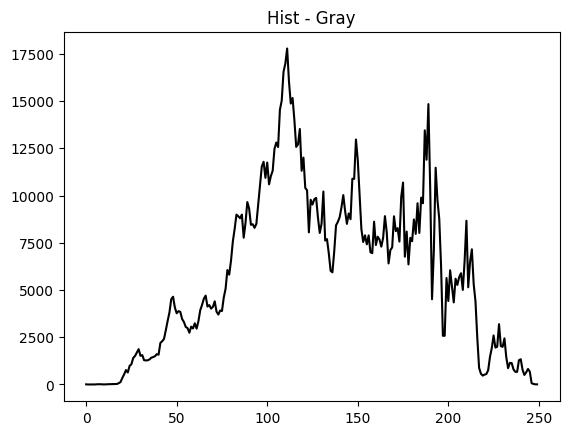

In [48]:
# Obtenemos su histograma
gray = cv2.calcHist([crpImg[0]], [0], None, [250], [0, 250])

# Le asignamos un nombre al histograma y lo guardamos en la carpeta
plt.clf()
plt.plot(gray, 'k')
plt.title("Hist - Gray")
# plt.savefig(fname + " - Gray.jpg")

---------------------------------------------------------------------------
# <h1> Iniciamos el procesamiento de las imagenes </h1>
---------------------------------------------------------------------------

In [14]:
# llamamos el metodo para obtener las imagenes
getImages(outDir)

# Imprimimos el tamaño de la lista de imagenes para comprobar que si se leyo correctamente
print(len(file_names))
print(len(imgs))






124
124


In [26]:

getChannels()



In [27]:
crpImages = selectLinesToCrop()


768
1333
768
1333
768
1333
768
1333
768
1830
756
1333
767
1549
729
1333
759
1344
768
1333
761
1552
768
1342
768
1343
768
1552
768
1334
768
1331
768
1342
766
1333
767
1333
768
1332
767
1341
757
1552
768
1342
770
1333
768
1333
759
1333
759
1331
768
1331
768
1331
768
1333
768
1343
768
1333
768
1549
768
1333
768
1346
768
1331
768
1331
768
1333
768
1920
768
1920
768
1920
768
1920
767
1920
757
1920
759
1920
768
1333
767
1553
766
1522
769
1547
768
1342
768
1333
768
1549
768
1342
768
1342
768
1342
768
1342
768
1342
768
1342
768
1331
768
1342
768
1342
768
1547
768
1547
768
1547
768
1342
768
1547
768
1342
768
1549
768
1547
768
1342
768
1342
768
1547
768
1342
768
1342
768
1549
768
1343
768
1549
768
1547
768
1342
768
1547
768
1340
768
1549
768
1549
768
1547
768
1331
768
1342
768
1342
768
1549
768
1342
768
1345
768
1345
768
1342
768
1549
768
1340
768
1342
768
1345
768
1331
768
1549
768
1335
768
1547
768
1547
768
1547
768
1342
768
1331
768
1331
768
1342
768
1547
768
1330
768
1342
768
1342
768
1331
7

In [32]:
print(crpImages)

None


In [37]:

showCroppedImages(crpImages)


TypeError: 'NoneType' object is not iterable

In [ ]:

thrImages(crpImages)